In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [16]:
import os, shutil
root = 'sample_computer_vision'
for split in ['train','val']:
    d = os.path.join(root, split)
    if not os.path.isdir(d):
        raise FileNotFoundError(f"경로 없음: {d}")
    for name in os.listdir(d):
        full = os.path.join(d, name)
        if os.path.isdir(full) and name.startswith('.'):
            print('삭제:', full)
            shutil.rmtree(full, ignore_errors=True)


삭제: sample_computer_vision\train\.ipynb_checkpoints
삭제: sample_computer_vision\val\.ipynb_checkpoints


In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'sample_computer_vision'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


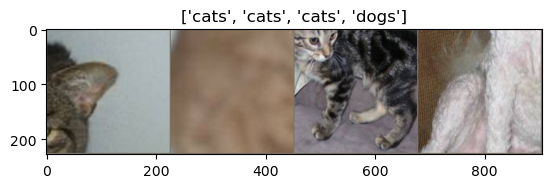

In [18]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5809 Acc: 0.7585
val Loss: 0.3261 Acc: 0.9000

Epoch 1/24
----------
train Loss: 0.5637 Acc: 0.7804
val Loss: 0.2025 Acc: 0.9050

Epoch 2/24
----------
train Loss: 0.4925 Acc: 0.7934
val Loss: 0.3532 Acc: 0.9100

Epoch 3/24
----------
train Loss: 0.4770 Acc: 0.8164
val Loss: 0.1270 Acc: 0.9500

Epoch 4/24
----------
train Loss: 0.4520 Acc: 0.8253
val Loss: 0.1184 Acc: 0.9750

Epoch 5/24
----------
train Loss: 0.3612 Acc: 0.8343
val Loss: 0.1513 Acc: 0.9500

Epoch 6/24
----------
train Loss: 0.3663 Acc: 0.8653
val Loss: 0.2252 Acc: 0.9200

Epoch 7/24
----------
train Loss: 0.3283 Acc: 0.8553
val Loss: 0.1035 Acc: 0.9800

Epoch 8/24
----------
train Loss: 0.3055 Acc: 0.8563
val Loss: 0.1171 Acc: 0.9750

Epoch 9/24
----------
train Loss: 0.2468 Acc: 0.8982
val Loss: 0.1059 Acc: 0.9750

Epoch 10/24
----------
train Loss: 0.2916 Acc: 0.8762
val Loss: 0.0984 Acc: 0.9850

Epoch 11/24
----------
train Loss: 0.2640 Acc: 0.8872
val Loss: 0.1010 Acc: 0.9800

Ep

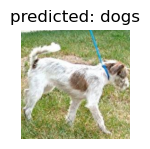

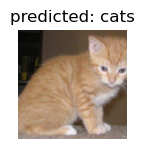

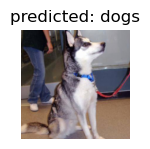

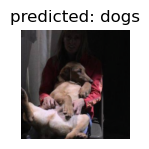

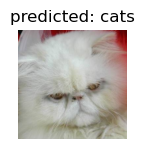

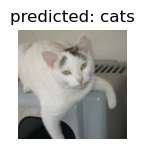

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4917 Acc: 0.7764
val Loss: 0.2148 Acc: 0.9200

Epoch 1/24
----------
train Loss: 0.5405 Acc: 0.7774
val Loss: 0.6780 Acc: 0.7750

Epoch 2/24
----------
train Loss: 0.6376 Acc: 0.7635
val Loss: 0.1624 Acc: 0.9550

Epoch 3/24
----------
train Loss: 0.4049 Acc: 0.8393
val Loss: 0.1391 Acc: 0.9400

Epoch 4/24
----------
train Loss: 0.5857 Acc: 0.7944
val Loss: 0.1677 Acc: 0.9400

Epoch 5/24
----------
train Loss: 0.3907 Acc: 0.8363
val Loss: 0.1048 Acc: 0.9600

Epoch 6/24
----------
train Loss: 0.4436 Acc: 0.8204
val Loss: 0.1367 Acc: 0.9550

Epoch 7/24
----------
train Loss: 0.3045 Acc: 0.8703
val Loss: 0.1418 Acc: 0.9500

Epoch 8/24
----------
train Loss: 0.3939 Acc: 0.8323
val Loss: 0.1238 Acc: 0.9550

Epoch 9/24
----------
train Loss: 0.3777 Acc: 0.8353
val Loss: 0.1092 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.3587 Acc: 0.8463
val Loss: 0.1148 Acc: 0.9600

Epoch 11/24
----------
train Loss: 0.3328 Acc: 0.8433
val Loss: 0.1113 Acc: 0.9750

Ep

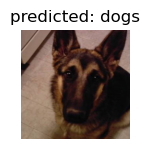

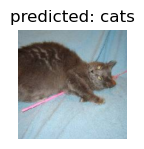

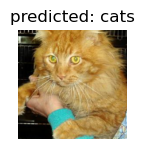

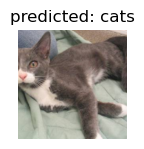

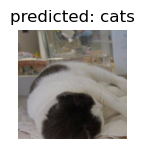

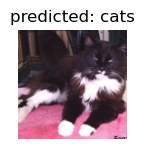

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()